In [2]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from tqdm import tqdm
from kaggle_secrets import UserSecretsClient

DATA = Path(
    '/kaggle/input/spacecraft-dataset')
WORKING = Path(
    '/kaggle/working/')
SAVED_RESULTS = Path(
    '/kaggle/input/spacecraft-component-segmentation')

In [3]:
pip install -U albumentation

ERROR: Could not find a version that satisfies the requirement albumentation (from versions: none)
ERROR: No matching distribution found for albumentation
Note: you may need to restart the kernel to use updated packages.


In [4]:
class SpacecraftDataset(Dataset):
    def __init__(self, transforms, split='train', limit=None):
        if split == 'train':
            self.image_path = DATA/'images/train'
            self.mask_path = DATA/'mask/train'
        else:
            self.image_path = DATA/'images/val'
            self.mask_path = DATA/'mask/val'
                            
        self.image_filenames = sorted(self.image_path.glob('*.png')) 
        
        # Limit training dataset if needed
        if limit and split == 'train':
            self.image_filenames = self.image_filenames[:limit]

        self.transform = transforms
        
    def __len__(self):
        return len(self.image_filenames)

    
    def __getitem__(self, idx):
        """ Try/except is to skip to the next index for corrupted images
            or when a mask is absent
        """
        try: 
            # Reading in an image
            image_filename = self.image_filenames[idx]   
            image = cv2.imread(str(image_filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                   
            # Reading in a mask
            mask_filename = (
                self.mask_path/
                    str(image_filename.name.split('.')[0] + '_mask.png'))
            if mask_filename.is_file():
                mask = cv2.imread(str(mask_filename))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            else:
                raise(IOError)
            
            # Mask one-hot encoding: background + 3 classes
            mask[mask!=0] = 1
            foreground = np.ubyte(np.sum(mask, axis=2))
            background = foreground^1
            background = background[:, :, np.newaxis]
            mask = (np.concatenate((background, mask), axis=2)
                    .astype(np.float32))
                                    
            # Transformations/augmentations
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            
            mask = mask.permute(2, 0, 1)  # (H,W,C) -> (C,H,W)
            return image, mask.to(torch.float32)
            
        except:
            # skip to the next index
            if idx + 1 <= self.__len__():
                return self.__getitem__(idx + 1)
            else:
                raise StopIteration

In [5]:
train_transforms = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomCropFromBorders(),
    A.OneOf([
        A.ColorJitter(hue=0.1),
        A.Equalize(by_channels=False),
        A.FancyPCA(),
        A.GaussNoise(),
        A.ImageCompression(),
        A.RandomGamma(),
        A.RandomToneCurve(),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25),
        A.AdvancedBlur(),
        A.RandomBrightnessContrast(brightness_limit=[-0.3, 0.1])
    ]),
    A.Resize(512, 512),
    A.RandomRotate90(),
    A.Normalize(),
    ToTensorV2()
    ])

valid_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = SpacecraftDataset(transforms=train_transforms)
valid_dataset = SpacecraftDataset(transforms=valid_transforms, split='val')

In [6]:
def normim_to_numpy(image, mask, size=(720, 1280)):
    """Converts a normalized torch.Tensor image
       to a "H,W,C" array of integers [0-255]
       Restores the original image size (1280x720)
    """
    transform = A.Compose([
        A.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225 ], 
                    max_pixel_value=1.),
        A.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1. ], 
                    max_pixel_value=1.),
        A.Resize(*size)
    ])
                
    image = image.numpy().transpose((1, 2, 0))
    mask = mask[1:,:,:].numpy().transpose((1, 2, 0))
    transformed = transform(image=image, mask=mask)
    image = transformed['image']
    mask = transformed['mask']
    image = (image * 255).astype(np.uint8)
    
    return np.ascontiguousarray(image), np.ascontiguousarray(mask)


def predict_mask(model, image):
    """Predicting a mask
    """
    model.eval()
    model.to('cpu')
    
    # predict logits [C, H, W]
    with torch.no_grad(): 
        pred_mask = model(image.unsqueeze(0))['out'].squeeze(0)    
        
    # class for each pixel [H, W]
    pred_mask = pred_mask.argmax(dim=0)  
       
    # one-hot [H, W, C] 
    pred_mask = torch.eye(4)[pred_mask.to(torch.int64)]  
      
    # background removed [H, W, 3 channels] == RGB image
    pred_mask = pred_mask[:,:,1:].numpy()
    
    transform = A.Resize(720, 1280)              
    image = image.numpy().transpose((1, 2, 0))
    pred_mask = transform(image=image, mask=pred_mask)['mask']
    
    return pred_mask


def display_random_examples(dataset, n=2, model=None):
    if model is None:
        fig, ax = plt.subplots(nrows=n, ncols=2, figsize=(10, 3*n))
    else:
        fig, ax = plt.subplots(nrows=n, ncols=3, figsize=(15, 3*n))
                
    for i in range(n):
        im_tensor, mask_tensor = dataset.__getitem__(np.random.randint(len(dataset)))
        image, mask = normim_to_numpy(im_tensor, mask_tensor)
                                
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image)
        ax[i, 1].imshow(mask, alpha=0.5)
          
        ax[i, 0].set_title('Image')
        ax[i, 1].set_title('Mask')
                 
        if model is not None:
            ax[i, 2].imshow(image)
            ax[i, 2].imshow(
                predict_mask(model, im_tensor), alpha=0.5)
            ax[i, 2].set_title('Predicted mask')
    
    [axi.set_axis_off() for axi in ax.ravel()]
    plt.tight_layout()
    plt.show()

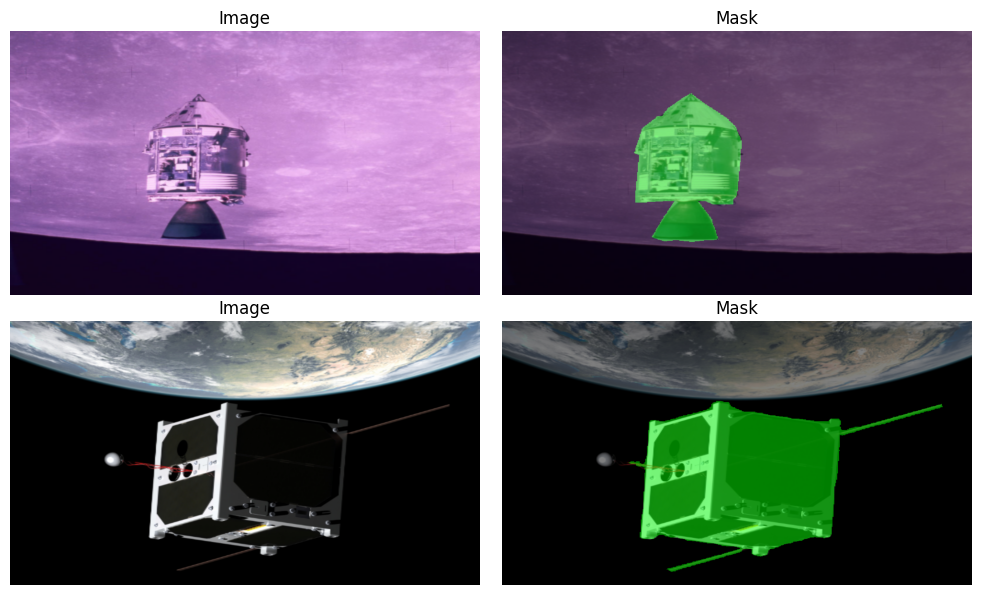

In [7]:
display_random_examples(train_dataset)

In [8]:
pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


In [9]:
print(f"Total images in train_dataset: {len(train_dataset)}")
print(f"Total images in valid_dataset: {len(valid_dataset)}")

Total images in train_dataset: 2145
Total images in valid_dataset: 350


In [10]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define train dataset with only 100 images
train_dataset = SpacecraftDataset(transforms=train_transforms, split='train', limit=2000)

# Keep full validation dataset
valid_dataset = SpacecraftDataset(transforms=valid_transforms, split='val')

# Load Dataset
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define U-Net Model with ResNet-34 Backbone
model = smp.Unet(
    encoder_name="resnet34",  # Use ResNet-34 as the encoder
    encoder_weights="imagenet",  # Use pre-trained ImageNet weights
    in_channels=3,  # 3-channel input (RGB)
    classes=4,  # 4 segmentation classes
    activation=None  # No activation since we use CrossEntropyLoss
).cuda()

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, masks)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), "satellite_segmentation_new.pth")
print("Model saved successfully!")

Epoch 1/20, Loss: 0.5398
Epoch 2/20, Loss: 0.2122
Epoch 3/20, Loss: 0.1573
Epoch 4/20, Loss: 0.1279
Epoch 5/20, Loss: 0.1158
Epoch 7/20, Loss: 0.1018
Epoch 8/20, Loss: 0.0927
Epoch 9/20, Loss: 0.0858
Epoch 10/20, Loss: 0.0848
Epoch 11/20, Loss: 0.0844
Epoch 12/20, Loss: 0.0795
Epoch 13/20, Loss: 0.0765
Epoch 14/20, Loss: 0.0769
Epoch 15/20, Loss: 0.0712
Epoch 16/20, Loss: 0.0685
Epoch 17/20, Loss: 0.0692
Epoch 18/20, Loss: 0.0687
Epoch 19/20, Loss: 0.0630
Epoch 20/20, Loss: 0.0645
Model saved successfully!


In [ ]:
import random

def display_random_examples(dataset, num_samples=2, model=None):
    """Displays original images, ground truth masks, and predicted masks."""
    if model is None:
        raise ValueError("Model is required for predictions.")

    model.eval()  # Set model to evaluation mode
    num_samples = min(num_samples, len(dataset))  # Avoid exceeding dataset size

    fig, ax = plt.subplots(nrows=num_samples, ncols=3, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)  # Random index selection
        image, mask = dataset[idx]  # Get image and mask

        # Move image to correct device and get model prediction
        image_tensor = image.unsqueeze(0).cuda() if torch.cuda.is_available() else image.unsqueeze(0).cpu()
        with torch.no_grad():
            pred_mask = model(image_tensor)  # Forward pass
            pred_mask = torch.argmax(pred_mask.squeeze(0), dim=0).cpu().numpy()  # Convert (4, 512, 512) -> (512, 512)

        # Convert image tensor to numpy for visualization
        image_np = image.permute(1, 2, 0).cpu().numpy()

        # Ensure ground truth mask is single-channel (select one class if needed)
        if mask.ndim == 3 and mask.shape[0] > 1:  
            mask_np = torch.argmax(mask, dim=0).cpu().numpy()  # Convert to (512, 512)
        else:
            mask_np = mask.cpu().numpy().squeeze()  # Ensure shape is (512, 512)

        # Display images
        ax[i, 0].imshow(image_np)
        ax[i, 0].set_title(f"Original Image {i+1}")
        ax[i, 0].axis("off")

        ax[i, 1].imshow(mask_np, cmap="jet")
        ax[i, 1].set_title(f"Ground Truth Mask {i+1}")
        ax[i, 1].axis("off")

        ax[i, 2].imshow(pred_mask, cmap="jet")
        ax[i, 2].set_title(f"Predicted Mask {i+1}")
        ax[i, 2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
display_random_examples(valid_dataset, num_samples=2, model=model)  # Use trained model